Christian Arendt Rasmussen s144466, Frederikke Lehmann s154109 & Clara Foss s154312

# Prediction of music track popularity using hierarchical regression

For the purpose of this project in the course 42186 Model-based machine learning F19 , we have chosen to work with data from Spotify. We have extracted the data ourselves using the Spotipy Python library inspired by the Kaggle data set (https://www.kaggle.com/nadintamer/top-tracks-of-2017/version/1). We have around 23000 observations (filtering dublets with reduce this dramatically), consisting of random tracks from the genres "pop", "metal", "classical" and "rap", respectively. Each song has a set of audio features, including popularity danceability, energy, tempo, key, etc., and this leads us to our research question:

### Research question
How can the popularity of a track be predicted with hierarchical regression using the observed audio features, with genre as the level?

#### Importing packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle
np.random.seed(42)
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
from IPython.display import Image

#### Loading data

In [2]:
df = pd.read_csv("genredata.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,485,485,Soolking,Vroom vroom,6Y4h3C3S6J1l3mlH4IgcZk,65,0.265000,0.794,177493,0.872,0.000000,2,0.1970,-4.285,1,0.0692,99.968,4,0.524,4
1,100,100,Godsmack,When Legends Rise,367RiGuLVLO3DTer4NuRLJ,57,0.000293,0.428,172826,0.914,0.000013,4,0.0869,-4.273,0,0.2810,124.115,4,0.468,2
2,4037,4037,Paul Gilbert,Fuzz Universe,1pxPtN4qoMvX8KmGscOxYr,37,0.001980,0.325,423453,0.945,0.412000,6,0.3470,-5.331,0,0.0519,131.923,4,0.372,3
3,4417,4417,Bloodbound,Moria,5CtKdgmm86gjAETNUqDJHQ,49,0.000554,0.493,340622,0.963,0.000036,8,0.0910,-5.421,1,0.1770,75.020,4,0.199,3
4,2631,2631,Katinka,Før Jeg Mødte Dig,1t4nON7nEOskoxzNqBRf6t,28,0.323000,0.476,269997,0.524,0.000003,7,0.2540,-7.600,1,0.0344,119.836,4,0.301,1


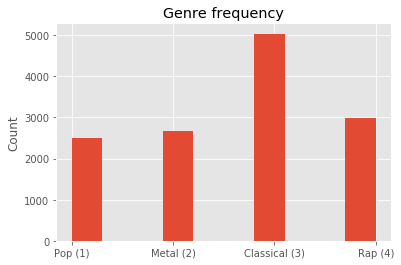

In [3]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(np.arange(1,5,step=1),["Pop (1)","Metal (2)","Classical (3)","Rap (4)"])
plt.show()

#### Subset to make model less time-consuming

In [4]:
#df = df[:200]
# separate between features/inputs (X) and target/output variables (y)
mat = df.drop(['Unnamed: 0','Unnamed: 0.1','artist_name','track_name','track_id'],axis = 1)
mat = mat.values

X = mat[:,1:-1].astype("float")
y = mat[:,0].astype("int")
ind = mat[:,-1].astype("int")

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

#### Splitting data into train and test set

In [5]:
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("Length of training set: %d" % len(y_train))
print("Length of test set: %d" % len(y_test))

Length of training set: 10560
Length of test set: 2640


In [6]:
print(X_train.shape)
print(np.mean(y_train))

(10560, 13)
47.00965909090909


## Baseline model - Simple Linear Regression

The generative process then becomes:

1. For each of the the 13 audio features $d \in \{1,\dots,D\}$  
    1. Draw a global mean parameter $\mu Prior_{d} \sim \mathcal{N}(0,10)$
    2. Draw a global variance parameter $\sigma Prior_{d} \sim \mbox{Cauchy}(0,10)$
    3. For each of the four music genres $i \in \{1,\dots,I\}$
      1. Draw $\beta_{d,i} \sim \mathcal{N}(\mu Prior_{d},\sigma Prior_{d})$
      2. Draw $\sigma_i \sim \mathcal{N}(0,10)$
      3. Draw $Intercept_i \sim \mathcal{N}(0,10)$
    
    
2. For each track $n=\{1,\dots,N\}$
    1. Draw target popularity $y_n \sim Normal(Intercept_{i}+\beta_{d,i}[:,ind[n]]' * X[n]',\sigma_{i}[ind[n]])$ (where ind[n] collects the correct beta value for the tracks genre) 

In [64]:
# define Stan model
model_definition_normal = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int<lower = 1> ind[N];
    matrix[N,D] X;
    vector<lower=0,upper=C> [N] y;
}

parameters {
    
     
   
    vector[D] beta;               // coefficients for predictors
    real intercept;          // intercept for audio feature for each class
    real<lower=0> sigma;     // variance for each audio feature for each class 
    
}

model {

    sigma ~ cauchy(50,100);
    intercept ~ normal(50,100);
    
    for (d in 1:D){
            beta[d] ~ normal(50,100);
            
            }

    
    for (n in 1:N){
       y[n] ~ normal(intercept + beta[ind[n]]' * X[n]', sigma); 
       //y[n] ~ categorical(softmax(intercept[ind[n]] + beta * X[n]'));
    }      
    
}
"""

In [65]:
# prepare data for Stan model
N, D = X_train.shape    # number of obs, number of columns
C = int(y_train.max())  # max popularity rating
I = ind.max()           # max number of genres
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=10560, D=13, C=100, I=4


In [66]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition_normal)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2b2995f01b62e0ceebc842d37d945f3a NOW.
C:\Users\Frederikke\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\FREDER~1\AppData\Local\Temp\tmpp315cmcq\stanfit4anon_model_2b2995f01b62e0ceebc842d37d945f3a_7616298056404340380.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Frederikke\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 2min 26s


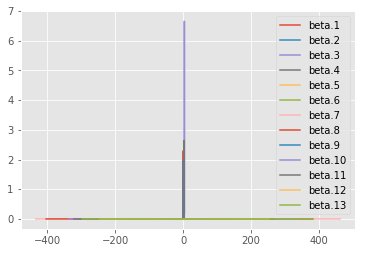

In [67]:
pystan_utils.vb_plot_variables(fit, "beta")

#### Predictions using pystan_utils

In [73]:
# get fitted parameters
intercept = pystan_utils.vb_extract_variable(fit, "intercept", var_type="real")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector", dims=(D))

In [76]:
print("pred: ", np.dot(beta.T, X_test.T).shape)
print("betamatrix: ", beta.T.shape)
print("data: ", X_test.shape)
print("intercepts: ", intercept)

pred:  (2640,)
betamatrix:  (13,)
data:  (2640, 13)
intercepts:  46.70776308299899


In [77]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [78]:
# convert back to the original scale
y_hat = intercept + np.dot(beta.T, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)

preds = y_hat
y_true = y_test 

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

print(preds)

predictions: [61.07392793 42.76125428 50.7780276  ... 36.43000315 40.60718885
 43.24089787]
true values: [75 64 26 ... 30  2 64]
CorrCoef: 0.411
MAE: 19.918
RMSE: 23.703
R2: 0.164
[61.07392793 42.76125428 50.7780276  ... 36.43000315 40.60718885
 43.24089787]


### Basine model - resuts

We get an RMSE of approximately 23.7. Next, we introduce hierarchical regression where we group by genre. 

## Hierachical Regression - Estimating y with a normal distribution in STAN
The generative process then becomes:

1. For each of the the 13 audio features $d \in \{1,\dots,D\}$  
    1. Draw $\beta_{d} \sim \mathcal{N}(0,10)$
    2. Draw $\sigma_{d} \sim \mathcal{N}(0,10)$
    3. Draw $Intercept_{d} \sim \mathcal{N}(0,10)$
    
    
2. For each track $n=\{1,\dots,N\}$
    1. Draw target popularity $y_n \sim Normal(Intercept_{i}+\beta_{d,i}[:,ind[n]]' * X[n]',\sigma_{d}[ind[n]])$ (where ind[n] collects the correct beta value for the tracks genre) 
    



### PGM:

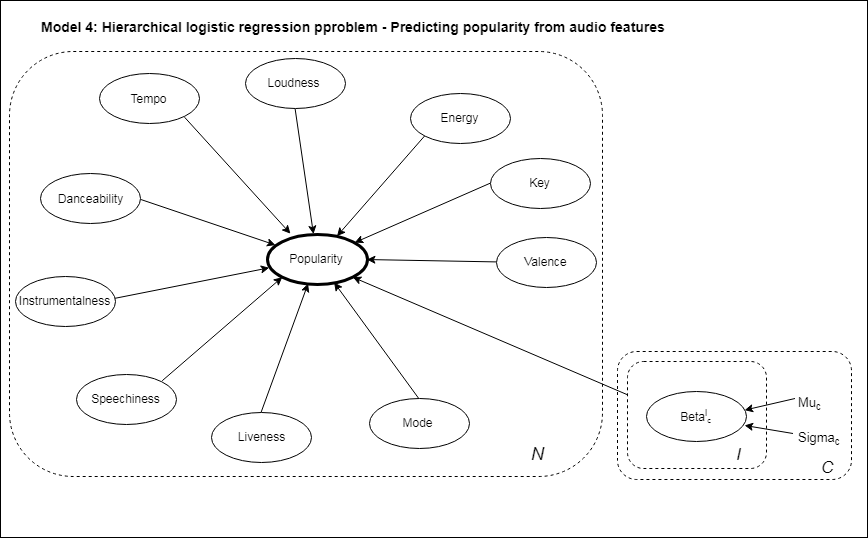

In [7]:
# Vi skal lige opdatere PGM'en på draw.io
Image(filename='PGM.PNG')

In [8]:
# define Stan model
model_definition_normal = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int<lower = 1> ind[N];
    matrix[N,D] X;
    vector<lower=0,upper=C> [N] y;
}

parameters {
    
     
    vector[D] mu_prior;             // global intercept mean
    vector<lower=0>[D] sigma_prior; // global variance mean
    matrix[D,I] beta;               // coefficients for predictors
    vector[I] intercept;          // intercept for audio feature for each class
    vector<lower=0>[I] sigma;     // variance for each audio feature for each class 
    
}

model {
    for (d in 1:D){
        mu_prior[d] ~ normal(50,100); // Hyper-prior
        sigma_prior[d] ~ cauchy(50,100); // Hyper-prior
        for (i in 1:I) {
            beta[d,i] ~ normal(mu_prior[d],sigma_prior[d]);
            sigma[i] ~ cauchy(50,100);
            intercept[i] ~ normal(50,100);
            }
        }

    
    for (n in 1:N){
       y[n] ~ normal(intercept[ind[n]] + beta[:,ind[n]]' * X[n]', sigma[ind[n]]); 
       //y[n] ~ categorical(softmax(intercept[ind[n]] + beta * X[n]'));
    }      
    
}
"""

In [9]:
# prepare data for Stan model
N, D = X_train.shape    # number of obs, number of columns
C = int(y_train.max())  # max popularity rating
I = ind.max()           # max number of genres
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=10560, D=13, C=100, I=4


In [10]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition_normal)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_906bf7b7398ecde975951556563ade94 NOW.
C:\Users\Frederikke\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\FREDER~1\AppData\Local\Temp\tmpa_4cb1uh\stanfit4anon_model_906bf7b7398ecde975951556563ade94_1812950396700206962.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Frederikke\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 2min 43s


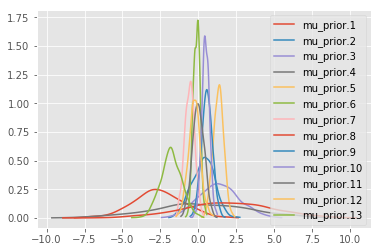

In [11]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

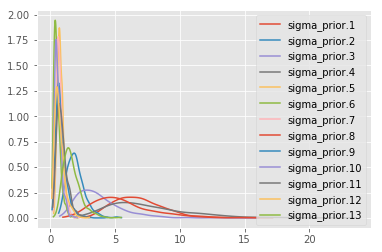

In [12]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

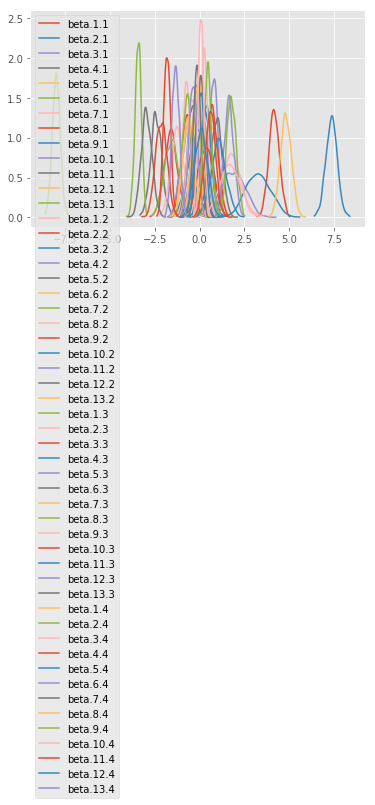

In [13]:
pystan_utils.vb_plot_variables(fit, "beta")

#### Predictions using pystan_utils

In [14]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
intercept = pystan_utils.vb_extract_variable(fit, "intercept", var_type="vector", dims=(I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(D,I))

In [15]:
print("pred: ", np.dot(beta.T, X_test.T).shape)
print("betamatrix: ", beta.T.shape)
print("data: ", X_test.shape)
print("intercepts: ", intercept.shape)

pred:  (4, 2640)
betamatrix:  (4, 13)
data:  (2640, 13)
intercepts:  (4,)


##### Accuracy test

In [20]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [21]:
# make predictions for test set
y_hat = []
for i in range(len(intercept)):
        y_hat.append(intercept[i] + np.dot(beta.T, X_test.T)[i])
        
y_hat = np.matrix(y_hat)


#Extracting the right prediction
yhat = np.zeros(y_hat.shape[1])
for n in range(y_hat.shape[1]):
    preds[n] = y_hat[ind_test[n]-1,n]
    

print("predictions:", preds)
print("true values:", y_test)

# True popularity values
y_true = y_test 

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

print(preds)

CorrCoef: 0.803
MAE: 12.169
RMSE: 15.490
R2: 0.643
[68.94288277 57.87786749 18.17586282 ... 17.25711847 18.57516213
 65.27716216]


In [26]:
y_true[0:20]

array([75, 64, 26, 69, 49, 35, 64, 28, 67, 61, 48, 23, 65, 10,  0, 40, 63,
       35, 12, 67])

In [28]:
preds[0:20]

array([68.94288277, 57.87786749, 18.17586282, 60.32205569, 47.92767369,
       15.44800547, 68.96744743, 17.54807992, 66.18692991, 66.70286071,
       46.36886363, 14.88006363, 67.12074455, 14.25526717, 17.0932387 ,
       15.59700279, 59.89695411, 12.85361034, 20.53232861, 62.98547445])

In [37]:
print("Genre intercepts: ", np.unique(intercept[ind_test-1]))
print("Audio feature parameters: \n", beta)

Genre intercepts:  [ 1.79556913 27.18075801 33.7351618  45.08314766]
Audio feature parameters: 
 [[2.41963887 2.22591998 1.16968564 2.40976747]
 [2.3213219  2.18585925 1.19665427 2.70888442]
 [3.21673689 3.47755681 0.77173347 4.65315714]
 [1.56525687 2.44893706 1.23489853 1.65228098]
 [2.53747899 2.14226185 1.08940163 2.57476996]
 [3.22249826 3.47192715 1.79337216 3.11902282]
 [2.16300898 2.39436165 2.01308104 2.74465187]
 [3.66755923 4.29645464 1.00980962 5.14224117]
 [3.00271168 2.88962877 2.28475896 3.51850298]
 [1.64430291 2.10649268 1.92849189 1.98432152]
 [2.14698348 4.09474266 3.08419191 1.26507183]
 [1.17357193 1.0735317  0.84072718 0.97992744]
 [2.4955813  2.05556033 1.13494635 3.06559602]]


Would be nice to extract the song title/artist to see if the popularity makes sense

## 2nd Model - Hierarchical Regression in STAN
The generative process then becomes:

1. For each of the the 13 audio features $d \in \{1,\dots,D\}$  
    1. Draw a global mean parameter $\mu Prior_{d} \sim \mathcal{N}(0,10)$
    2. Draw a global variance parameter $\sigma Prior_{d} \sim \mbox{Cauchy}(0,10)$
    3. For each of the four music genres $i \in \{1,\dots,I\}$
      1. Draw $\beta_{d,i} \sim \mathcal{N}(\mu Prior_{d},\sigma Prior_{d})$
      2. Draw $\sigma_i \sim \mathcal{N}(0,10)$
      3. Draw $Intercept_i \sim \mathcal{N}(0,10)$
    
    
2. For each track $n=\{1,\dots,N\}$
      1. Draw target popularity $y_n \sim beta(\exp(Intercept_{i}+\beta1_{d,i}[:,ind[n]]' * X[n]'),\exp(Intercept_{i}+\beta1_{d,i}[:,ind[n]]' * X[n]'))$ (where ind[n] collects the correct beta value for the tracks genre



In [37]:
# define Stan model
model_definition_beta = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int<lower = 1> ind[N];
    matrix[N,D] X;
    int<lower=0,upper=C> y[N];
}

parameters {
    
     
    vector[D] mu_prior;                    // global intercept mean
    vector<lower=0>[D] sigma_prior;        // global variance mean
    matrix[D,I] beta1;            // coefficients for predictors
    matrix[D,I] beta2;            // coefficients for predictors
    vector[I] intercept1;         // intercept for audio feature for each class
    vector[I] intercept2;         // intercept for audio feature for each class
       
}

model {
    
    for (d in 1:D){
        mu_prior[d] ~ normal(50,100);      // Hyper-prior
        print(mu_prior[d])
        sigma_prior[d] ~ cauchy(50,100);   // Hyper-prior
        for (i in 1:I) {
            beta1[d,i] ~ normal(mu_prior[d],sigma_prior[d]);
            beta2[d,i] ~ normal(mu_prior[d],sigma_prior[d]);
            intercept1[i] ~ normal(50,100);
            intercept2[i] ~ normal(50,100);
            }
        }
    
    for (n in 1:N){
        y[n] ~ beta(exp(intercept1[ind[n]] + beta1[:,ind[n]]' * X[n]'), exp(intercept2[ind[n]] + beta2[:,ind[n]]' * X[n]'));
        
        
    }    
}
"""

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [38]:
# prepare data for Stan model
N, D = X_train.shape    # number of obs, number of columns
C = int(y_train.max())  # max popularity rating
I = ind.max()           # max number of genres
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=10560, D=13, C=100, I=4


In [39]:
print(np.min(X_train))
print(np.argmin(X_train, axis=0))

X_train[30,]

-7.201251843022332
[4821  337 5661 1784   16    3 4935 3799    1  337  337  337  337]


array([ 1.19168949, -0.58490057, -0.31716462, -1.43725838,  1.60784955,
        1.07843767, -0.8010872 , -2.19710511, -1.2230069 , -0.5287473 ,
        0.65300409, -1.58911375, -1.20952476])

In [40]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition_beta)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2cb3ed9eb69441a0791bb281a4c5edc0 NOW.
C:\Users\Frederikke\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\FREDER~1\AppData\Local\Temp\tmp_j0igo7q\stanfit4anon_model_2cb3ed9eb69441a0791bb281a4c5edc0_3606641924302137949.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


RuntimeError: Initialization failed.

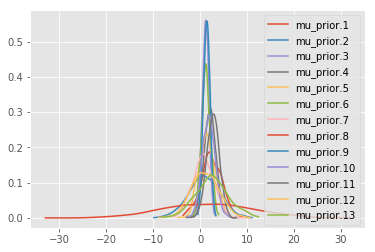

In [32]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

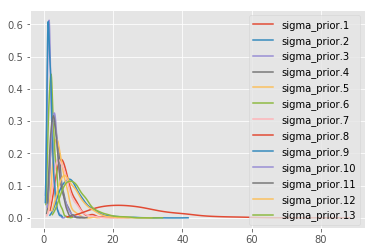

In [33]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

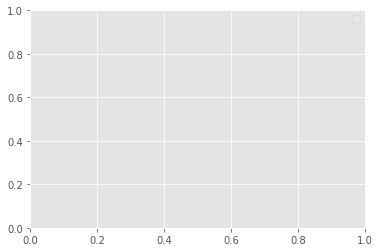

In [35]:
pystan_utils.vb_plot_variables(fit, "beta1")

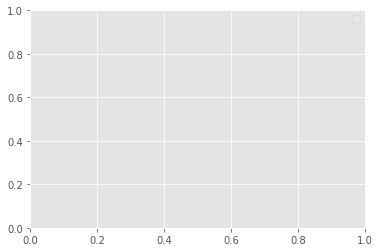

In [36]:
pystan_utils.vb_plot_variables(fit, "beta2")

#### Predictions using pystan_utils

In [34]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
intercept1 = pystan_utils.vb_extract_variable(fit, "intercept1", var_type="vector", dims=(I))
intercept2 = pystan_utils.vb_extract_variable(fit, "intercept2", var_type="vector", dims=(I))
beta1 = pystan_utils.vb_extract_variable(fit, "beta1", var_type="matrix", dims=(D,I))
beta2 = pystan_utils.vb_extract_variable(fit, "beta2", var_type="matrix", dims=(D,I))

ValueError: cannot reshape array of size 0 into shape (13,4)

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per track. 

In [81]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

NameError: name 'alpha' is not defined

In [24]:
print(y_hat[0:20])

[[66.97884005 59.91391384 57.08275477 ... 58.73635527 63.79321166
  63.59892188]
 [62.49685087 57.87786749 58.8186912  ... 57.22493939 70.10376766
  61.54165132]
 [33.30457507 27.10708489 18.17586282 ... 17.25711847 18.57516213
  38.62576155]
 [68.94288277 64.77529462 60.66409101 ... 59.0977274  60.74501456
  65.27716216]]
